# Identifying Pulsar Stars Using the HTRU2 Dataset
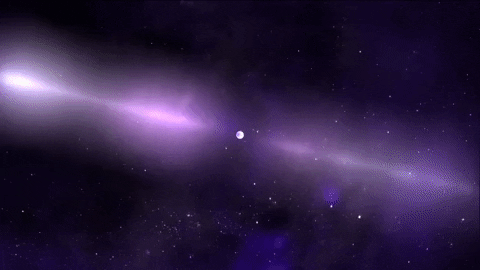

## Introduction

Pulsars are a rare type of Neutron star that produce radio emissions detectable here on Earth that are influenced due to radio frequency interference (RFI) and noise making the signals difficult to find. The aim of this project is to classify a given data signal into pulsars and non-pulsars by understanding if there exists a correlation between the given variables and their class. We predict that if these features are useful indicators of a star’s class, then they will produce accurate predictions when applied to the testing data. 

Using the HTRU2 dataset with 17898 manually labeled observations, we will mainly look over the integrated profile and the DM-SNR values and their data information such as skewness, kurtosis etc. to deduce a model for pulsar classification.

## Preliminary Exploratory Data Analysis

In [2]:
library(tidyverse)
library(tidymodels)
print("Required libraries loaded!")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

── Attaching packages ────────────────────────────────────── tidymodels 0.1.4 ──

✔ broom        0.7.12     ✔ rsample      0.1.1 
✔ dials        0.1.0      ✔ tune         0.1.6 
✔ infer        1.0.0      ✔ workflows    0.2.4 
✔ modeldata    0.1.1      ✔ workflowsets 0.1.0 
✔ parsnip      0.1.7      ✔ yardstick    0.0.9 
✔ recipes      0.2.0      

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks

[1] "Required libraries loaded!"


#### First, let's load the dataset

In [3]:
# Set the seed for reproducibility
set.seed(27)

# Make column names
columns <- c("mean_integrated_profile", "std_integrated_profile", "kurtosis_integrated_profile",
             "skewness_integrated_profile", "mean_dmsnr", "std_dmsnr", 
             "kurtosis_dmsnr", "skewness_dmsnr", "class")

# Load the dataset
pulsar <- read_csv("https://raw.githubusercontent.com/garrethlee/DSCI-Group-Project/main/pulsar.csv", 
                   col_names = columns) %>%
            mutate(class=as_factor(class)) 

# Take a sneak peek into the data
head(pulsar)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): mean_integrated_profile, std_integrated_profile, kurtosis_integrate...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_integrated_profile,std_integrated_profile,kurtosis_integrated_profile,skewness_integrated_profile,mean_dmsnr,std_dmsnr,kurtosis_dmsnr,skewness_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


#### Let's then check for missing values within the dataset

In [4]:
total_missing_values <- sum(is.na(pulsar))
paste("There are", total_missing_values ,"missing values in the dataset")

[1] "There are 0 missing values in the dataset"

#### Then, we can summarize across columns to see key statistics, such as mean, max, min, median, etc.

In [5]:
key_statistics <- pulsar %>% 
                    select(mean_integrated_profile:skewness_dmsnr) %>% 
                    pivot_longer(everything(), names_to = "column") %>%
                    group_by(column) %>%
                    summarize(min=min(value), max=max(value), 
                              mean=mean(value), median=median(value), 
                              count=n(), missing_values=sum(is.na(.)))
key_statistics

column,min,max,mean,median,count,missing_values
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
kurtosis_dmsnr,-3.1392696,34.539844,8.3035561,8.4335147,17898,0
kurtosis_integrated_profile,-1.8760112,8.069522,0.4778573,0.2232400,17898,0
mean_dmsnr,0.2132107,223.392141,12.6143997,2.8018395,17898,0
mean_integrated_profile,5.8125000,192.617188,111.0799683,115.0781250,17898,0
skewness_dmsnr,-1.9769756,1191.000837,104.8577087,83.0645561,17898,0
skewness_integrated_profile,-1.7918860,68.101622,1.7702790,0.1987104,17898,0
std_dmsnr,7.3704322,110.642211,26.3265147,18.4613156,17898,0
std_integrated_profile,24.7720418,98.778911,46.5495316,46.9474791,17898,0


#### Now, let's plot the data and look at the distribution of each column.

For this, I will be making a function, `plot_histogram`, that does a ggplot histogram for every column, except for the `class` column.

[[1]]

[[2]]


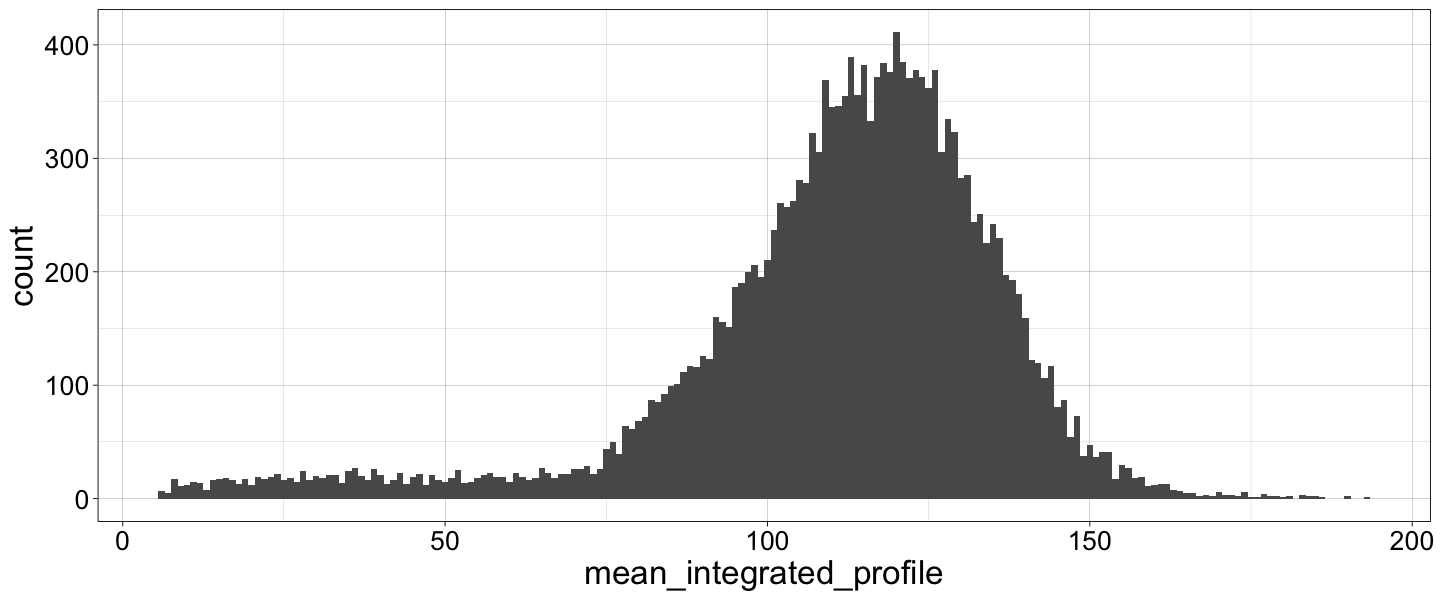


[[3]]


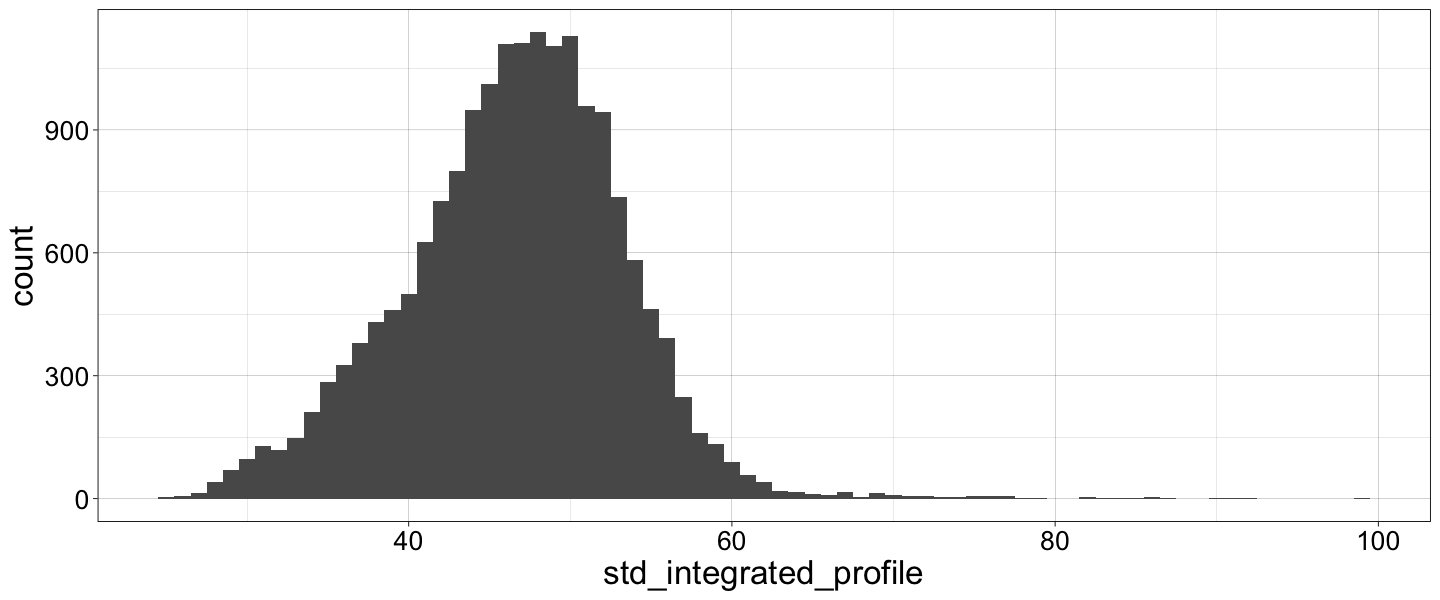


[[4]]


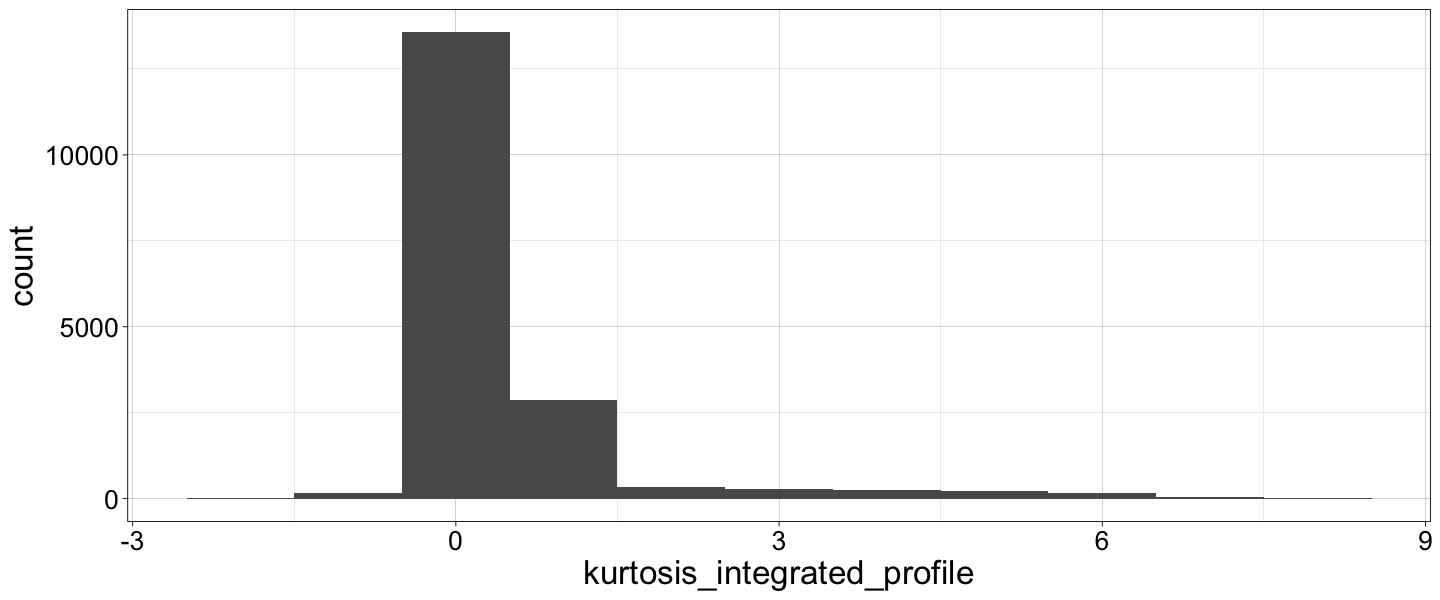


[[5]]


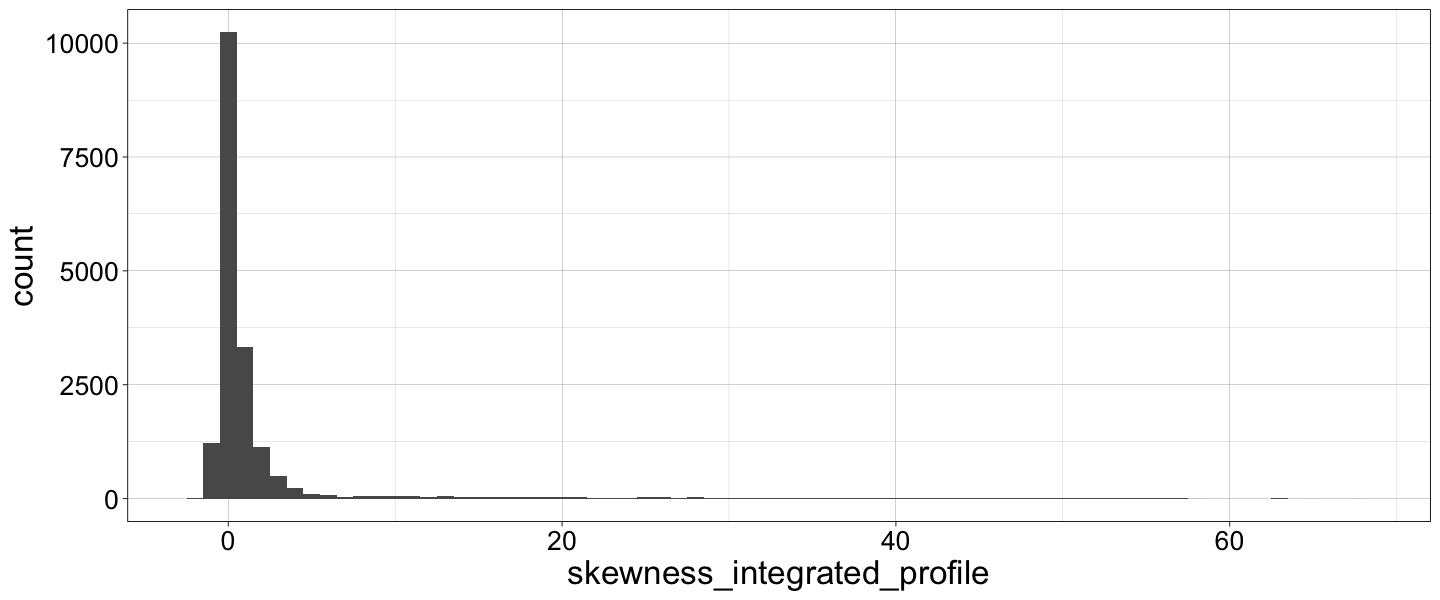


[[6]]


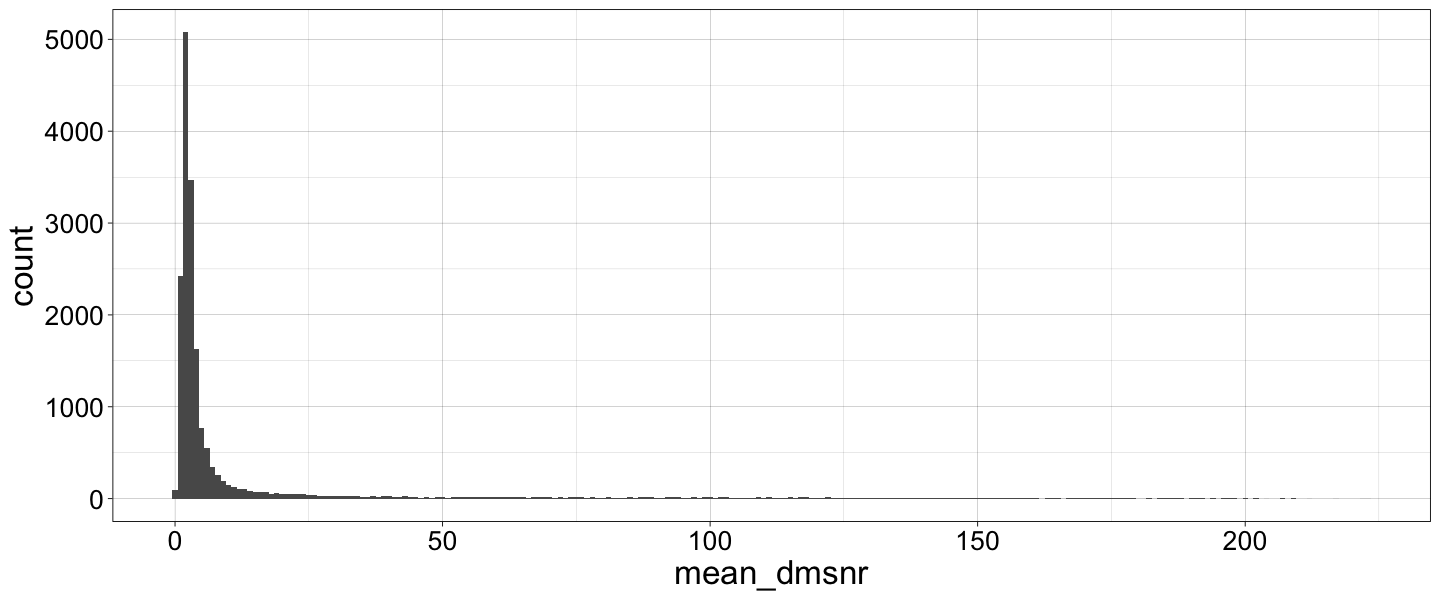


[[7]]


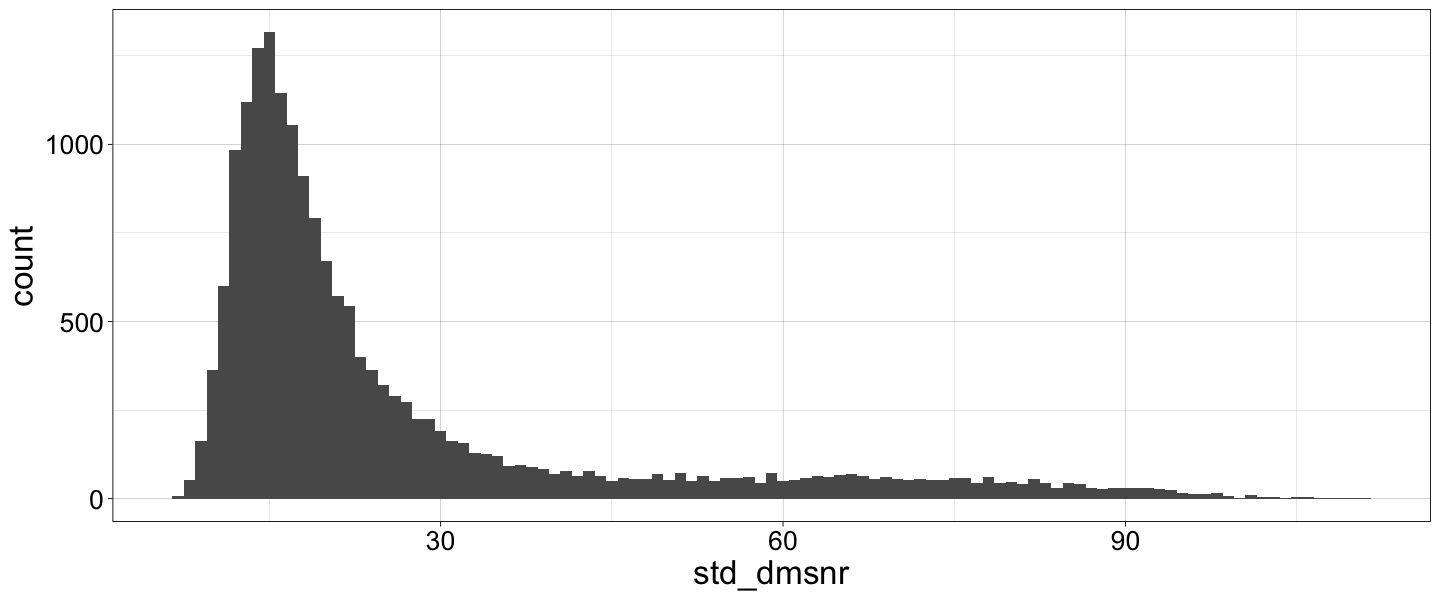


[[8]]


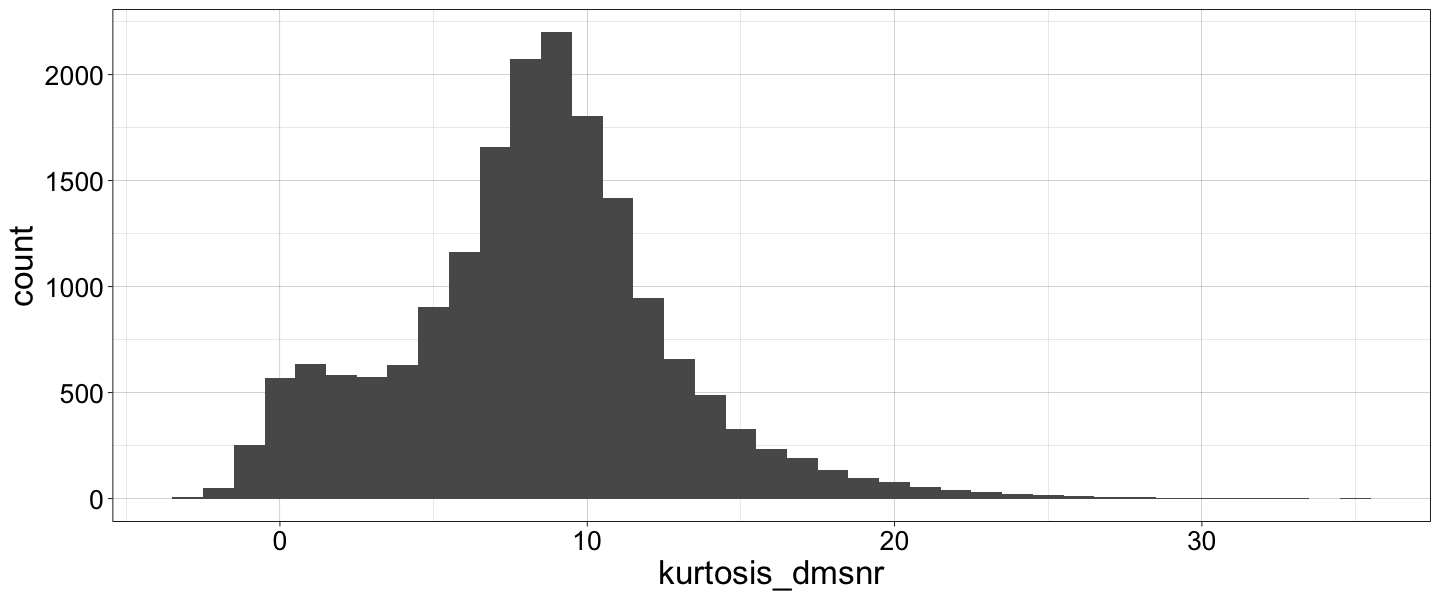

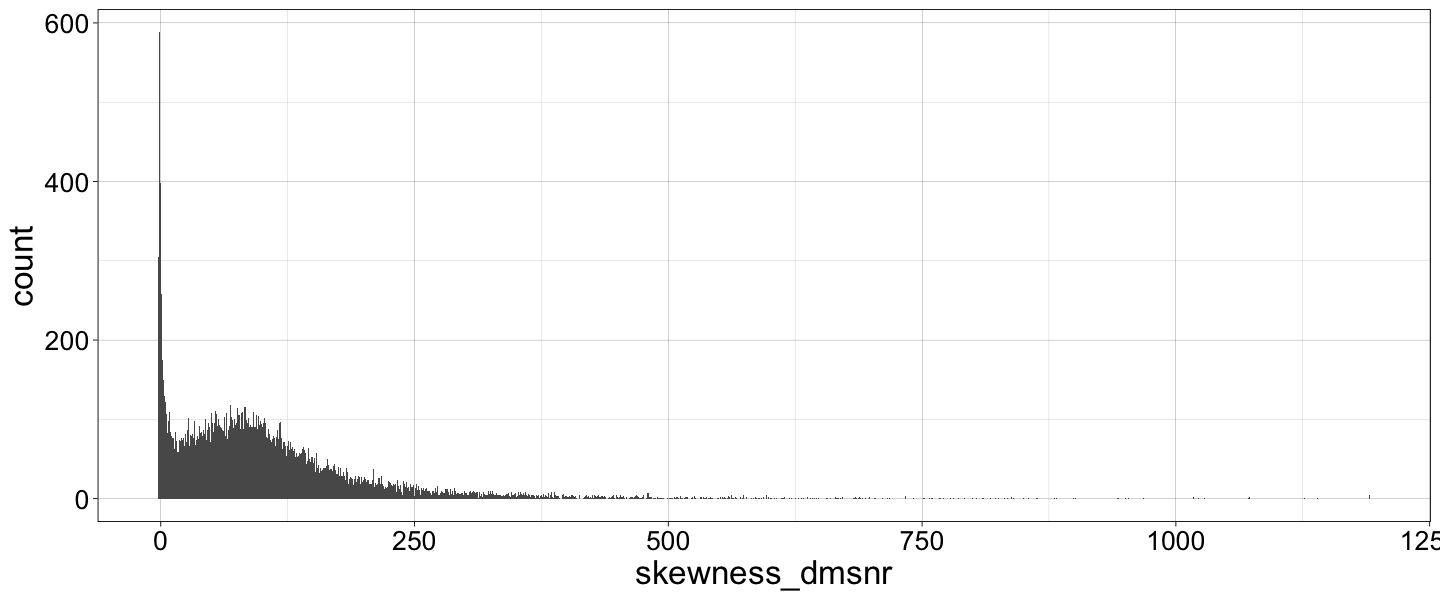

In [21]:
options(repr.plot.width=12, repr.plot.height=5)

columns_except_class <- columns[-9]

plot_histogram <- function(dataset, col){
    plot <- dataset %>% 
                ggplot(aes_string(x=col)) +
                geom_histogram(binwidth=1) +
                theme_linedraw() +
                theme(text=element_text(size=20)) 
    return(plot)
}

myplots <- lapply(columns_except_class, plot_histogram, data=pulsar)
show(myplots)

## Feature Selection and Scaling

Some features have massively different scales from each other. For isntance, the `skewness_dmsnr` feature has a scale up to thousands, while the `kurtosis_integrated_profile` feature only ranges between -3 to 9. This calls for feature scaling, to make sure the model can interpret every single observation according to a uniform scale

In [11]:
pulsar_recipe <- pulsar %>%
                    recipe(class ~ .) %>%
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors())
pulsar_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          8

Operations:

Scaling for all_predictors()
Centering for all_predictors()

## Methods - Data Analysis, Usable Variables, and Visualizations

After the preliminary analysis, we further investigate each variable by plotting them against “class” using scatterplots. Such visualization allows us to observe the strength of correlations between variables and the target class, as stronger associations will demonstrate clearer divisions. Combined with more complex analysis from additional resources, we can determine which variables serve as better classifiers and then apply them to our training and testing data, following standard procedures taught in this course.

For this project, we predict that both scatter plots and bar plots are effective ways of visualizing results. A scatter plot with different colors to categorize the target class variable and shapes to differentiate training data from testing data (and within the testing data to distinguish true +/- and false +/-) provides an overview of the dataset, whereas a bar plot for percent counts of true +, true -, false +, false - observations shows the model’s accuracy.


## Expected Outcomes and Significance

Our expectation for this project is to successfully differentiate the class 0 and 1 variables by constructing both scatter plots and bar plots. From the dataset, we obtained the information of the number of observations. There are 1,639 positive observations, which is approximately 9.2%. Yet there are 16,259 negative observations, which take the major proportion of 91.8%. This information has brought us into a prediction of as the counts number in the plots gets higher, the probability of the observation is negative. 

Therefore, the expected outcome is:
- For mean_profile and kurtosis_dmsnr value, the value with the maximum counts is larger than the mean value. Therefore, the observations whose mean_profile and kurtosis_dsmnr value is higher than the mean will probably be negative.
- For kurtosis_profile, skewness_profile, mean_dmsnr and skewness_dmsnr values, the value with the maximum counts is smaller than the mean value. Therefore, negative observations are more likely to be on the left side of the mean va/lue.

The findings have provided us an overall direction to build our model and make in-depth observations, which enlightened us with an idea of the difference between positive and negative observations. Furthermore, we have learned that all pulsars have their unique profile shape, which is like human fingerprints. From this feature, we are interested in a future question of what is the relationship between each variable in the dataset?
